# Generate Data for Segmentataion & Detection


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
seg_path = "/content/drive/MyDrive/cv_data/seg"
bbox_path = "/content/drive/MyDrive/cv_data/bbox"

In [ ]:
import numpy as np
import cv2

def dummy_polygon_generator(num_samples,
                            image_size=(256, 256),
                            max_polygons=3):
    """
    반환값:
      img: (3, H, W) 채널 우선 노이즈 배경 이미지 (B, G, R)
      mask_stack: (max_polygons, H, W) 다각형별 이진 마스크
                  생성된 다각형이 없거나 부족해도 항상 max_polygons 채널 유지
    """
    h, w = image_size
    for _ in range(num_samples):
        # 1) 배경 컬러 노이즈 (H, W, 3)
        img = np.random.randint(0, 256, size=(h, w, 3), dtype=np.uint8)

        # 2) 다각형 개수 결정 (0 ~ max_polygons)
        if np.random.rand() < 0.9:
            num_polygons = max_polygons
        else:
            num_polygons = np.random.randint(0, max_polygons + 1)  # 0도 허용

        masks = []
        for _ in range(num_polygons):
            # 정점 수, 중심, 반지름 등 랜덤 설정
            num_vertices = np.random.randint(3, 8)
            cx, cy = np.random.randint(0, w), np.random.randint(0, h)
            min_r, max_r = int(min(h, w)*0.1), int(min(h, w)*0.33)
            base_r = np.random.randint(min_r, max(min_r+1, max_r))
            angles = np.linspace(0, 2*np.pi, num_vertices, endpoint=False)

            pts = []
            for a in angles:
                r = base_r * np.random.uniform(0.5, 1.0)
                x = int(cx + r*np.cos(a)); y = int(cy + r*np.sin(a))
                pts.append([np.clip(x,0,w-1), np.clip(y,0,h-1)])
            pts = np.array([pts], dtype=np.int32)

            # 이미지에 다각형 그리기
            color = tuple(np.random.randint(50,256,3).tolist())
            cv2.fillPoly(img, [pts], color)

            # 마스크 생성
            m = np.zeros((h, w), dtype=np.uint8)
            cv2.fillPoly(m, [pts], 255)
            masks.append(m)

        # 3) 실제 마스크 스택 만들기, 부족 채널은 0으로 패딩
        if masks:
            mask_stack = np.stack(masks, axis=0)  # (num_polygons, H, W)
        else:
            mask_stack = np.zeros((0, h, w), dtype=np.uint8)

        # 부족한 만큼 0 채널 추가
        if mask_stack.shape[0] < max_polygons:
            pad = np.zeros((max_polygons - mask_stack.shape[0], h, w), dtype=np.uint8)
            mask_stack = np.concatenate([mask_stack, pad], axis=0)

        # 4) 채널 우선 이미지로 변환
        img_cf = np.transpose(img, (2, 0, 1))    # (3, H, W)
        yield img_cf, mask_stack                  # mask_stack.shape == (max_polygons, H, W)


img: (3, 256, 256) mask: (3, 256, 256)
img: (3, 256, 256) mask: (3, 256, 256)
img: (3, 256, 256) mask: (3, 256, 256)


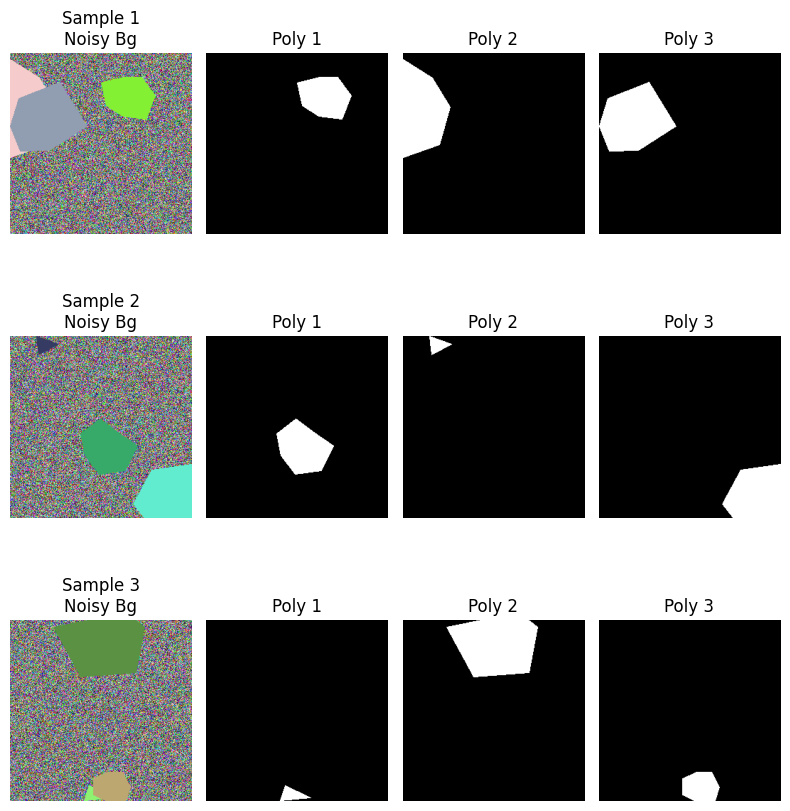

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# 시각화 파라미터
num_samples  = 3
max_polygons = 3
gen = dummy_polygon_generator(num_samples=num_samples, max_polygons=max_polygons)

fig, axes = plt.subplots(num_samples, 1 + max_polygons,
                         figsize=(2*(1+max_polygons), 3*num_samples))

for idx, (img_cf, mask_stack) in enumerate(gen):
    # 채널 우선 형태 확인
    print("img:", img_cf.shape, "mask:", mask_stack.shape)
    # (C, H, W) -> (H, W, C)
    img_disp = np.transpose(img_cf, (1, 2, 0))
    # BGR->RGB
    img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)

    # 원본
    ax = axes[idx, 0]
    ax.imshow(img_disp)
    ax.axis('off')
    ax.set_title(f'Sample {idx+1}\nNoisy Bg')

    h, w = img_disp.shape[:2]
    # 각 폴리곤 마스크
    for j in range(max_polygons):
        ax = axes[idx, j+1]
        if j < mask_stack.shape[0]:
            ax.imshow(mask_stack[j], cmap='gray')
        else:
            ax.imshow(np.zeros((h,w), dtype=np.uint8), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Poly {j+1}')

plt.tight_layout()
plt.show()


### Saving Data

In [ ]:
# import os
# from tqdm import tqdm
# import numpy as np
# import cv2

# num_samples   = 300     # 생성할 총 샘플 수
# image_size    = (256, 256)
# max_polygons  = 3          # 채널 수 고정
# base_dir      = seg_path
# img_dir       = os.path.join(base_dir, "images")
# mask_dir      = os.path.join(base_dir, "masks_multichannel")
# os.makedirs(img_dir, exist_ok=True)
# os.makedirs(mask_dir, exist_ok=True)

# gen = dummy_polygon_generator(
#     num_samples=num_samples,
#     image_size=image_size,
#     max_polygons=max_polygons
# )

# for idx, (img_cf, mask_stack) in enumerate(tqdm(gen, total=num_samples), start=1):
#     filename = f"{idx:06d}.png"

#     # 1) img_cf: (3, H, W) → (H, W, 3) 로 변환 후 저장
#     img_to_save = np.transpose(img_cf, (1, 2, 0))  # (H, W, C)
#     cv2.imwrite(os.path.join(img_dir, filename), img_to_save)

#     # 2) mask_stack padding (이미 max_polygons 보장됨) → (H, W, C)
#     mask_multichannel = np.transpose(mask_stack, (1, 2, 0))  # (H, W, max_polygons)
#     cv2.imwrite(os.path.join(mask_dir, filename), mask_multichannel)

# print(f"총 {num_samples}개의 이미지와 다채널 마스크 생성 완료.")


### Thread Pool

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

NUM_SAMPLES = 50
IMAGE_SIZE = (256, 256)
MAX_POLYGONS = 3
MAX_WORKERS = 2

BASE_DIR = seg_path
IMG_DIR  = os.path.join(BASE_DIR, "images")
MASK_DIR = os.path.join(BASE_DIR, "masks_multichannel")
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(MASK_DIR, exist_ok=True)

def process_one(idx):
    gen = dummy_polygon_generator(1, IMAGE_SIZE, MAX_POLYGONS)
    img_cf, mask_stack = next(gen)
    fname = f"{idx:06d}.png"

    # (C,H,W) -> (H,W,C)
    img = np.transpose(img_cf, (1,2,0))
    mask = np.transpose(mask_stack, (1,2,0))

    ok1 = cv2.imwrite(os.path.join(IMG_DIR,  fname), img)
    ok2 = cv2.imwrite(os.path.join(MASK_DIR, fname), mask)
    if not (ok1 and ok2):
        print(f"!! failed saving {fname}")

# 스레드 풀로 실행
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as exe:
    list(tqdm(exe.map(process_one, range(1, NUM_SAMPLES+1)),
              total=NUM_SAMPLES,
              desc="Generating dataset"))

print("Done!")


Generating dataset: 100%|██████████| 50/50 [00:01<00:00, 48.25it/s]

Done!


### Object Detection Dataset

In [ ]:
# import os
# import json
# import numpy as np
# import cv2
# from tqdm import tqdm
# from concurrent.futures import ThreadPoolExecutor

# # --------------------------------------------------
# # 1) 기존 Segmentation 데이터 로드
# # --------------------------------------------------
# SEG_BASE_DIR = seg_path
# SEG_IMG_DIR = os.path.join(SEG_BASE_DIR, "images")
# SEG_MASK_DIR = os.path.join(SEG_BASE_DIR, "masks_multichannel")

# # --------------------------------------------------
# # 2) COCO Detection 데이터셋 설정
# # --------------------------------------------------
# OUTPUT_DIR = bbox_path
# ANNOTATION_FILE= os.path.join(OUTPUT_DIR, "annotations.json")
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# MAX_POLYGONS = 3  # segmentation 시 사용한 max_polygons 값

# # 이미지 파일 목록
# image_files = sorted([
#     f for f in os.listdir(SEG_IMG_DIR)
#     if f.lower().endswith(('.png', '.jpg', '.jpeg'))
# ])
# NUM_SAMPLES = len(image_files)

# # COCO 형식 초기화
# coco = {
#     "info": {"description": "Segmentation→Detection Dataset", "version": "1.0"},
#     "licenses": [],
#     "images": [],
#     "annotations": [],
#     # 채널별 anomaly label 정의 (원하시는 이름으로 바꿔주세요)
#     "categories": [
#         {"id": i+1, "name": f"anomaly_{i+1}", "supercategory": "anomaly"}
#         for i in range(MAX_POLYGONS)
#     ]
# }

# # 전역 annotation id 카운터
# ann_id_counter = [1]

In [ ]:
import os, json, numpy as np, cv2
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

SEG_BASE_DIR = seg_path
SEG_IMG_DIR = os.path.join(SEG_BASE_DIR, "images")
SEG_MASK_DIR = os.path.join(SEG_BASE_DIR, "masks_multichannel")
OUTPUT_DIR = bbox_path
os.makedirs(OUTPUT_DIR, exist_ok=True)
ANNOTATION_FILE = os.path.join(OUTPUT_DIR, "annotations.json")

MAX_POLYGONS = 3

coco = {
    "info": {"description":"Seg→Det", "version":"1.0"},
    "licenses": [],
    "images": [],
    "annotations": [],
    "categories": [
        {"id":i+1, "name":f"anomaly_{i+1}", "supercategory":"anomaly"}
        for i in range(MAX_POLYGONS)
    ]
}

# 전역 ann_id 카운터
ann_id = 1

def process_image(idx, fn):
    global ann_id
    # 1) 이미지 메타
    img = cv2.imread(os.path.join(SEG_IMG_DIR, fn))
    h, w = img.shape[:2]
    img_info = {"id":idx, "file_name":fn, "width":w, "height":h}

    # 2) 마스크 불러오기 (알파채널 포함 가능)
    m = cv2.imread(os.path.join(SEG_MASK_DIR, fn), cv2.IMREAD_UNCHANGED)
    # 3채널 초과(알파 붙은)→BGR만 취하기
    if m.ndim==3 and m.shape[2] > MAX_POLYGONS:
        m = m[..., :MAX_POLYGONS]
    # 그레이스케일일 때 차원 맞춰주기
    if m.ndim==2:
        m = m[..., np.newaxis]

    anns = []
    # 3) 채널별 contour→bbox
    for ch in range(min(m.shape[2], MAX_POLYGONS)):
        # 1) 이진화
        _, mb = cv2.threshold(m[...,ch], 127, 255, cv2.THRESH_BINARY)
        # 2) 폴리곤이 없으면 건너뛰기
        if cv2.countNonZero(mb) == 0:
            continue

        # 3) 외곽선 찾고 boundingRect
        cnts, _ = cv2.findContours(mb, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # (여러 컨투어가 나올 수 있지만, dummy generator는 1개)
        x, y, bw, bh = cv2.boundingRect(cnts[0])
        area = int(cv2.contourArea(cnts[0]))

        anns.append({
            "id":          ann_id,
            "image_id":    idx,
            "category_id": ch+1,
            "bbox":        [int(x), int(y), int(bw), int(bh)],
            "area":        area,
            "iscrowd":     0
        })
        ann_id += 1

    return img_info, anns

# 4) 병렬 처리
image_files = sorted([f for f in os.listdir(SEG_IMG_DIR) if f.endswith(".png")])
with ThreadPoolExecutor(8) as exe:
    for img_info, alist in tqdm(exe.map(lambda p: process_image(*p),
                                       enumerate(image_files,1)),
                                 total=len(image_files)):
        coco["images"].append(img_info)
        coco["annotations"].extend(alist)

# 5) 저장
with open(ANNOTATION_FILE, "w", encoding="utf-8") as f:
    json.dump(coco, f, ensure_ascii=False, indent=2)

print(f"Saved {len(coco['images'])} images, {len(coco['annotations'])} anns")


100%|██████████| 300/300 [00:03<00:00, 80.71it/s] 


Saved 300 images, 853 anns


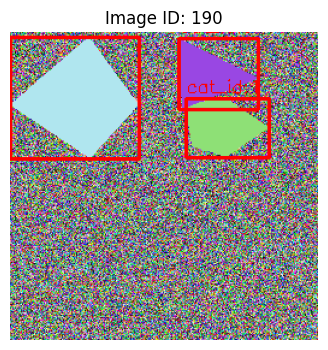

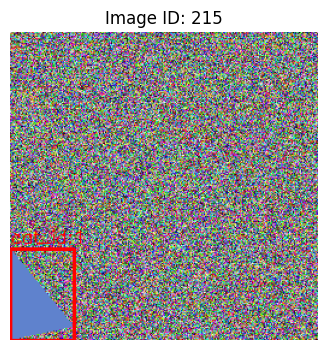

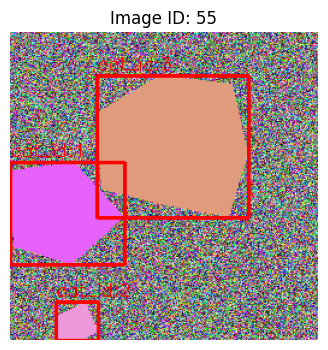

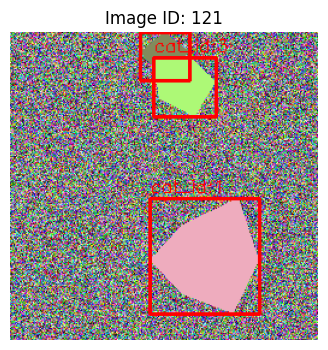

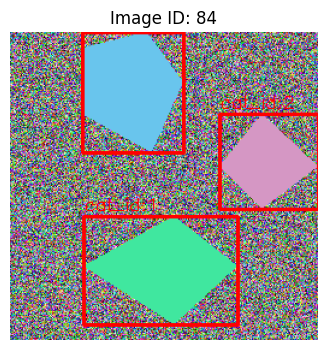

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# 0) 이미지·어노테이션 로드는 이미 끝났다고 가정
# coco["images"], coco["annotations"], SEG_IMG_DIR 등이 정의되어 있어야 함

# 1) COCO annotations 를 image_id 별로 묶기
anns_by_image = {}
for ann in coco["annotations"]:
    anns_by_image.setdefault(ann["image_id"], []).append(ann)

# 2) coco["images"]에서 dict만 flatten
flat_images = [img for img in coco["images"] if isinstance(img, dict)]

# 3) id→파일명 매핑
img_id_to_fname = {img["id"]: img["file_name"] for img in flat_images}

# 4) 샘플링
all_ids    = list(img_id_to_fname.keys())
sample_ids = random.sample(all_ids, k=min(5, len(all_ids)))

# 5) 시각화
for img_id in sample_ids:
    fn  = img_id_to_fname[img_id]
    img = cv2.imread(os.path.join(SEG_IMG_DIR, fn))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for ann in anns_by_image.get(img_id, []):
        x, y, w, h = map(int, ann["bbox"])
        cv2.rectangle(img, (x, y), (x+w, y+h), (255,0,0), 2)
        cv2.putText(img, f"cat_id:{ann['category_id']}", (x, y-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(f"Image ID: {img_id}")
    plt.axis('off')

plt.show()
